/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - loss: 0.0323
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 0.0061
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - loss: 0.0045
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.0040
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 0.0040
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - loss: 0.0035
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - loss: 0.0032
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 0.0033
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - loss: 0.0026
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - loss: 0.0028
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - loss: 0.0023
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0028
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - loss: 0.0021
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - loss: 0.0020
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - l

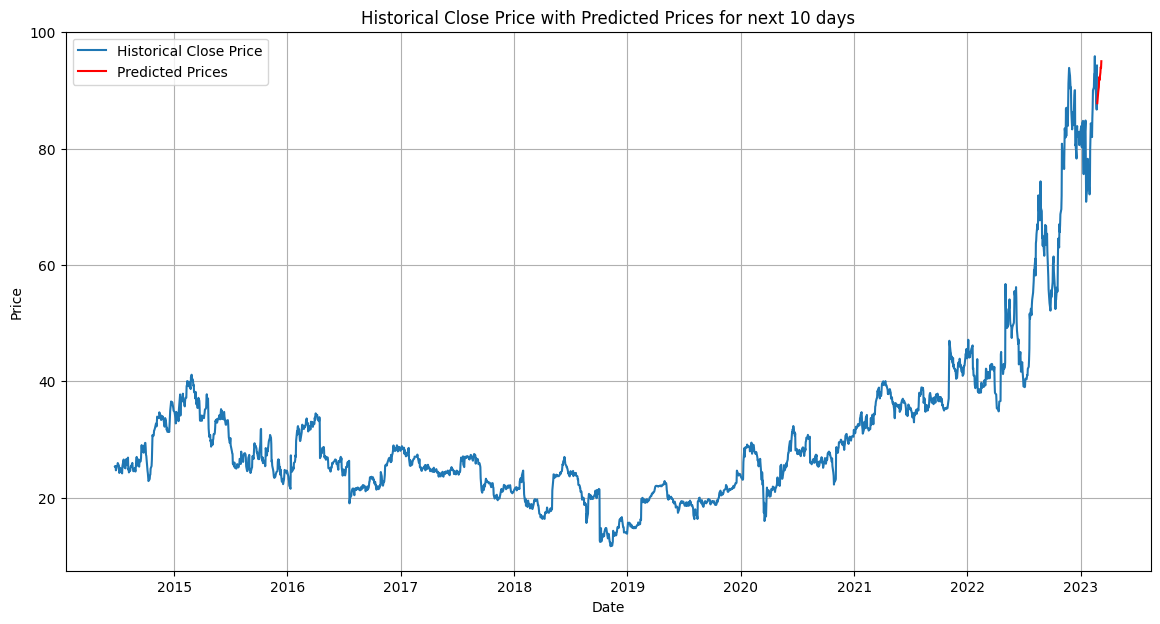

In [3]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. Import data
file_path = './data/SMCI.csv'
data = pd.read_csv(file_path)

# Data Cleaning
columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']
for column in columns_to_convert:
    data[column] = data[column].str.replace('$', '').str.replace(',', '').astype(float)

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-02-24')].copy()

# 2. Setup Variables
time_steps = 90
future_steps = 10  # Number of future time steps to predict

# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training data
x_train, y_train = [], []
for i in range(time_steps, len(train_data) - future_steps + 1):
    x_train.append(train_data[i - time_steps:i, 0])
    y_train.append(train_data[i:i + future_steps, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 4. Build Model
def build_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=future_steps))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 5. Training
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=50, batch_size=64)

# 6. Make Multi-Step Prediction
def make_multi_step_prediction(model, data, scaler, future_steps):
    last_data = data[-time_steps:]
    last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
    
    predicted_prices = model.predict(last_data)
    predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
    
    return predicted_prices

# Execute steps 4, 5, 6
model = build_model()
train_model(model, x_train, y_train)

# Predict future 10 days' Close/Last prices
predicted_prices = make_multi_step_prediction(model, train_data, scaler, future_steps=future_steps)

# Find the last date in the training set
last_date = train_set['Date'].max()
print(f"last_date:{last_date}")

future_dates = []
print(f"Predicted Close Prices for the next {future_steps} days:")
for i, price in enumerate(predicted_prices, 1):
    future_date = (last_date + pd.offsets.BDay(i)).strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date)
    future_dates.append(future_date)
    print(f"Day {i} ({future_date}): {price[0]}")

# Plotting function
def plot_historical_and_predicted(train_set, predicted_prices, future_dates, future_steps):
    plt.figure(figsize=(14, 7))
    plt.plot(train_set['Date'], train_set['Close/Last'], label='Historical Close Price')
    plt.plot(future_dates, predicted_prices, color='red', label='Predicted Prices')
    plt.title(f'Historical Close Price with Predicted Prices for next {future_steps} days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_historical_and_predicted(train_set, predicted_prices, future_dates, future_steps=future_steps)


In [4]:
data

,Date,Close/Last,Volume,Open,High,Low
2515,2014-06-24,25.340,243530,25.52,25.9800,25.303
2514,2014-06-25,25.270,491864,25.24,25.4900,24.570
2513,2014-06-26,25.450,342669,26.00,26.0000,25.210
2512,2014-06-27,24.690,1482237,25.24,25.4050,24.690
2511,2014-06-30,25.270,648122,24.69,25.3900,24.610
...,...,...,...,...,...,...
4,2024-06-14,844.540,6598781,846.93,872.0000,825.610
3,2024-06-17,887.410,8911764,857.40,921.9100,828.090
2,2024-06-18,920.010,8762073,897.00,938.8800,883.310
1,2024-06-20,917.635,13432940,961.29,1014.0200,900.320


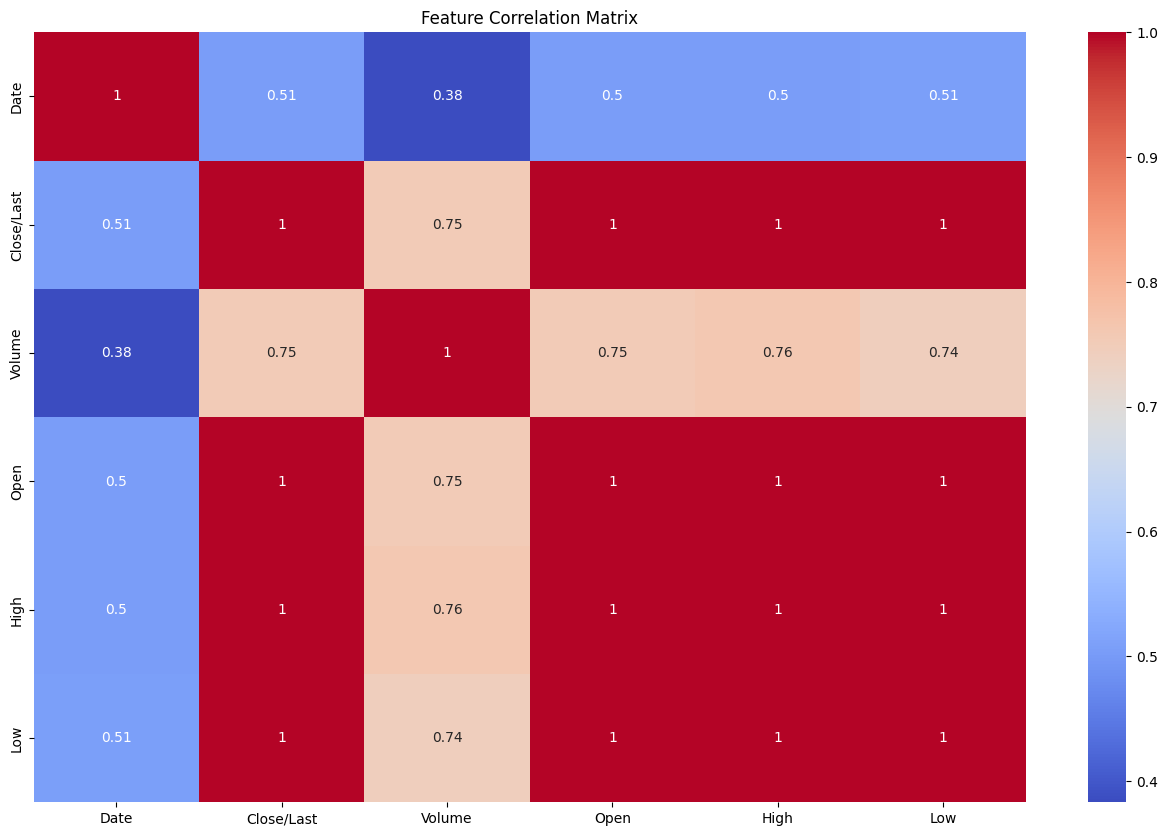

In [5]:
import seaborn as sns

# 可视化各特征之间的关联性
correlation_matrix = data.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()